# Small data and deep learning
This mini-project proposes to study several techniques for improving challenging context, in which few data and resources are available.

In [0]:
%matplotlib inline

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should not exceed 2MB. Please name your notebook (LASTNAME)\_(FIRSTNAME).ipynb, zip/tar it with any necessary files required to run your notebook, in a compressed file named (LASTNAME)\_(FIRSTNAME).X where X is the corresponding extension. Zip/tar files exceeding 2MB will not be considered for grading. Submit the compressed file via the submission link provided on the website of the class.__

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1:__ Propose a dataloader or modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py in order to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set. 

### Dependencies

In [0]:
import matplotlib.pyplot as plt

### Import downloader behaviours

In [0]:
from PIL import Image
import os
import os.path
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data

import os
import os.path
import hashlib
import errno
from torch.utils.model_zoo import tqdm

## UTILS FUNCTION from https://github.com/pytorch/vision/blob/master/torchvision/datasets/utils.py

def check_integrity(fpath, md5=None):
    """ Check integrity of downloaded file using md5 digital signature
    
    """
    if md5 is None:
        return True
    if not os.path.isfile(fpath):
        return False
    md5o = hashlib.md5()
    with open(fpath, 'rb') as f:
        # read in 1MB chunks
        for chunk in iter(lambda: f.read(1024 * 1024), b''):
            md5o.update(chunk)
    md5c = md5o.hexdigest()
    if md5c != md5:
        return False
    return True


def download_url(url, root, filename=None, md5=None):
    """Download a file from a url and place it in root.
    Args:
        url (str): URL to download file from
        root (str): Directory to place downloaded file in
        filename (str, optional): Name to save the file under. If None, use the basename of the URL
        md5 (str, optional): MD5 checksum of the download. If None, do not check
    """
    from six.moves import urllib

    root = os.path.expanduser(root)
    if not filename:
        filename = os.path.basename(url)
    fpath = os.path.join(root, filename)

    makedir_exist_ok(root)

    # downloads file
    if os.path.isfile(fpath) and check_integrity(fpath, md5):
        print('Using downloaded and verified file: ' + fpath)
    else:
        try:
            print('Downloading ' + url + ' to ' + fpath)
            urllib.request.urlretrieve(
                url, fpath,
                reporthook=gen_bar_updater()
            )
        except OSError:
            if url[:5] == 'https':
                url = url.replace('https:', 'http:')
                print('Failed download. Trying https -> http instead.'
                      ' Downloading ' + url + ' to ' + fpath)
                urllib.request.urlretrieve(
                    url, fpath,
                    reporthook=gen_bar_updater()
                )

def makedir_exist_ok(dirpath):
    """
    Python2 support for os.makedirs(.., exist_ok=True)
    """
    try:
        os.makedirs(dirpath)
    except OSError as e:
        if e.errno == errno.EEXIST:
            pass
        else:
            raise
            
def gen_bar_updater():
    pbar = tqdm(total=None)

    def bar_update(count, block_size, total_size):
        if pbar.total is None and total_size:
            pbar.total = total_size
        progress_bytes = count * block_size
        pbar.update(progress_bytes - pbar.n)

    return bar_update

## CIFAR DATASET DOWNLOADER from https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py
    
class CIFAR10(data.Dataset):
    """`CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """
    base_folder = 'cifar-10-batches-py'
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    tgz_md5 = 'c58f30108f718f92721af3b95e74349a'
    train_list = [
        ['data_batch_1', 'c99cafc152244af753f735de768cd75f'],
        ['data_batch_2', 'd4bba439e000b95fd0a9bffe97cbabec'],
        ['data_batch_3', '54ebc095f3ab1f0389bbae665268c751'],
        ['data_batch_4', '634d18415352ddfa80567beed471001a'],
        ['data_batch_5', '482c414d41f54cd18b22e5b47cb7c3cb'],
    ]

    test_list = [
        ['test_batch', '40351d587109b95175f43aff81a1287e'],
    ]
    meta = {
        'filename': 'batches.meta',
        'key': 'label_names',
        'md5': '5ff9c542aee3614f3951f8cda6e48888',
    }

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        self.data = []
        self.targets = []

        # now load the picked numpy arrays
        for file_name, checksum in downloaded_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)
            with open(file_path, 'rb') as f:
                if sys.version_info[0] == 2:
                    entry = pickle.load(f)
                else:
                    entry = pickle.load(f, encoding='latin1')
                self.data.append(entry['data'])
                if 'labels' in entry:
                    self.targets.extend(entry['labels'])
                else:
                    self.targets.extend(entry['fine_labels'])

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

        self._load_meta()

    def _load_meta(self):
        path = os.path.join(self.root, self.base_folder, self.meta['filename'])
        if not check_integrity(path, self.meta['md5']):
            raise RuntimeError('Dataset metadata file not found or corrupted.' +
                               ' You can use download=True to download it')
        with open(path, 'rb') as infile:
            if sys.version_info[0] == 2:
                data = pickle.load(infile)
            else:
                data = pickle.load(infile, encoding='latin1')
            self.classes = data[self.meta['key']]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

    def _check_integrity(self):
        root = self.root
        for fentry in (self.train_list + self.test_list):
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        download_url(self.url, self.root, self.filename, self.tgz_md5)

        # extract file
        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str


class CIFAR100(CIFAR10):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    This is a subclass of the `CIFAR10` Dataset.
    """
    base_folder = 'cifar-100-python'
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
    filename = "cifar-100-python.tar.gz"
    tgz_md5 = 'eb9058c3a382ffc7106e4002c42a8d85'
    train_list = [
        ['train', '16019d7e3df5f24257cddd939b257f8d'],
    ]

    test_list = [
        ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
    ]
    meta = {
        'filename': 'meta',
        'key': 'fine_label_names',
        'md5': '7973b15100ade9c7d40fb424638fde48',
    }

### Run test downloading

In [0]:
# Define dataset path and batch to use
DATASET_PATH = "dataset"
TRAIN_BATCH_PATH = "/".join([DATASET_PATH, "cifar-10-batches-py", "data_batch_1"])
TEST_BATCH_PATH = "/".join([DATASET_PATH, "cifar-10-batches-py", "test_batch"])


In [5]:
# Download dataset
print("Download train dataset")
downloader_train = CIFAR10(root=DATASET_PATH, train=True, transform=None, target_transform=None, download=True)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Download train dataset


170500096it [00:05, 31147309.37it/s]                               


### Unpack the dataset

In [0]:
def unpickle(file):
    """ Unpack data from file into dataset format
    :param file: path to the loaded file
    """
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

train_data_dict = unpickle(TRAIN_BATCH_PATH)
test_data_dict = unpickle(TEST_BATCH_PATH)

X_train shape (100, 32, 32, 3)
X_left shape (9900, 32, 32, 3)
X_test shape (10000, 32, 32, 3)


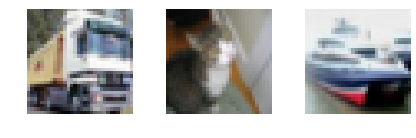

In [7]:
def custom_dataset_process(data_dict, n_start = 0, n_end=None):
    """ Load the CIFAR10 data as intended for this project
    :param data_dict: dict, dictionnary generated by the unpickle function
    :param n_start: integer, default=None, index value of the first elements to take
    :param n_end: integer, default=None, index value of the last elements to take
    :return x: np.array, data array with shape n*32*32*3, with n number of images, of shape 32*32 in 3 colors"""
    
    labels = data_dict[b"labels"][n_start:n_end]
    data = data_dict[b"data"][n_start:n_end]
        
    les_im = np.array(data)
    les_im_reshape = []
    for id_im, im in enumerate(les_im):
        im_reshape = np.rot90(im.reshape((32, 32, 3), order="F"), k=3)
        les_im_reshape.append(im_reshape)
    
    les_im_reshape = np.array(les_im_reshape)
    return les_im_reshape, labels

X_train, X_train_labels = custom_dataset_process(train_data_dict, n_start=0, n_end=100)
X_left, X_left_labels = custom_dataset_process(train_data_dict, n_start=100, n_end=None)
X_test, X_test_labels = custom_dataset_process(test_data_dict)

def show_dataset():
    """ Show 1 sample from each dataset to check or loading, importation and treatement
    """
    to_show = [["X_train", X_train], ["X_left", X_left], ["X_test", X_test]]
    for i, X in enumerate(to_show):
        
        print(X[0], "shape", X[1].shape)
        plt.subplot(1, len(to_show), i+1)
        plt.axis('off')
        plt.tight_layout()
        plt.imshow(X[1][1])

show_dataset()

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2:__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

Evaluation of the training procedure may be difficult because of the low number of labeled data we are using for the model training. We may have quite a hard time resolving overfitting problems: we have few gold data.

As seen in the class, solutions exists:
- We can use semi-supervized learning to try to make guesses about unlabeled train data
- Use transfer learning, and just fine-tune our model without the need of a huge great dataset
- Weak supervision or traditional supervision are also existing solutions, but we will not use them as they involve to ask for a new labelling round, even at higher/abstract level.

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performances with reported number from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the laerning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper: http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context, as those researchers had access to GPUs.

## ResNet architectures

__Question 3:__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1409.1556 ). If possible, please report the accuracy obtained on the whole dataset, as well as the reference paper/GitHub link you might have used.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (~5 minutes).

In [0]:
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models


class Args:
    def __init__(self, arch="resnet18", workers=4, epochs=99, start_epoch=0, batch_size=16, lr=0.1, momentum=0.9, weight_decay=1e-4, print_freq=50, resume="", evaluate=False, pretrained=False, n_early_stop=None, n_top=3):
        """ Define and store the hyperparams needed and used by the model training procedure
        :param arch: default="resnet18"
        :param workers: default=4
        :param epochs: default=99
        :param start_epoch: default=0
        :param batch_size: default=16
        :param lr: default=0.1
        :param momentum: default=0.9
        :param weight_decay: default=1e-4
        :param print_freq: default=50
        :param resume: default=""
        :param evaluate: default=False
        :param pretrained: default=False
        """
        self.arch = arch
        self.workers = workers
        self.epochs = epochs
        self.start_epoch = start_epoch
        self.batch_size = batch_size
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.print_freq = print_freq
        self.resume = resume
        self.evaluate = evaluate
        self.pretrained = pretrained
        self.n_early_stop = n_early_stop
        self.n_top = n_top


class MyDataset(torch.utils.data.Dataset):
    """ Build a personnal dataset provider
    """

    def __init__(self, X_tensor, Y_tensor, transform):
        """
        :param X_tensor: np.numpy or torch.tensor, X tensor of data
        :param Y_tensor: np.numpy or torch.tensor, data label
        :param transform: transform to apply on X tensor before item provide
        """
        assert len(X_tensor) == len(Y_tensor)
        self.X_tensor = X_tensor
        self.Y_tensor = Y_tensor
        self.transform = transform

    def __getitem__(self, index):
        return tuple([self.transform(self.X_tensor[index]), self.Y_tensor[index]])

    def __len__(self):
        return len(self.X_tensor)

    
class AverageMeter(object):
        """Computes and stores the average and current value"""
        def __init__(self):
            self.reset()

        def reset(self):
            self.val = 0
            self.avg = 0
            self.sum = 0
            self.count = 0

        def update(self, val, n=1):
            self.val = val
            self.sum += val * n
            self.count += n
            self.avg = self.sum / self.count

        
class Classifier:
    def __init__(self, args, transf):
        self.args = args
        self.transf = transf
        model_names = sorted(name for name in models.__dict__
            if name.islower() and not name.startswith("__")
            and callable(models.__dict__[name]))
        print("model_names", model_names)

        self.best_prec1 = 0
        self.les_epoch = []
        self.les_train_loss = []
        self.les_val_loss = []
        self.les_train_top_1 = []
        self.les_train_top_n = []
        self.les_val_top_1 = []
        self.les_val_top_n = []

    def run_training(self):
        
        # create model
        if self.args.pretrained:
            print("=> using pre-trained model '{}'".format(self.args.arch))
            model = models.__dict__[self.args.arch](pretrained=True)
        else:
            print("=> creating model '{}'".format(self.args.arch))
            model = models.__dict__[self.args.arch]()

        if self.args.arch.startswith('alexnet') or self.args.arch.startswith('vgg'):
            model.features = torch.nn.DataParallel(model.features)
            model.cuda()
        else:
            model = torch.nn.DataParallel(model).cuda()

        cudnn.benchmark = True

        # Train dataset 
        train_dataset =  MyDataset(X_train, X_train_labels, transform=self.transf)
        train_loader = torch.utils.data.DataLoader(
            dataset=train_dataset,
            batch_size=self.args.batch_size, shuffle=True,
            num_workers=self.args.workers, pin_memory=True)

        # Validation dataset
        val_dataset =  MyDataset(X_test, X_test_labels, transform=self.transf)
        val_loader = torch.utils.data.DataLoader(
            dataset=val_dataset,
            batch_size=self.args.batch_size, shuffle=False,
            num_workers=self.args.workers, pin_memory=True)

        # define loss function (criterion) and pptimizer
        criterion = nn.CrossEntropyLoss().cuda()

        optimizer = torch.optim.SGD(model.parameters(), self.args.lr,
                                    momentum=self.args.momentum,
                                    weight_decay=self.args.weight_decay)

        if self.args.evaluate:
            self.validate(val_loader, model, criterion)
            return

        for epoch in range(self.args.start_epoch, self.args.epochs):
            self.adjust_learning_rate(optimizer, epoch)

            # train for one epoch
            self.train(train_loader, model, criterion, optimizer, epoch)

            # evaluate on validation set
            prec1 = self.validate(val_loader, model, criterion)

            # remember best prec@1 and save checkpoint
            is_best = prec1 > self.best_prec1
            self.best_prec1 = max(prec1, self.best_prec1)
            self.save_checkpoint({
                'epoch': epoch + 1,
                'arch': self.args.arch,
                'state_dict': model.state_dict(),
                'best_prec1': self.best_prec1,
            }, is_best)
            
            if self.args.n_early_stop is not None and self.should_early_stop(n_check_last=self.args.n_early_stop):
                break


    def train(self, train_loader, model, criterion, optimizer, epoch):
        """ Well, lets train the model using provided dataset and params
        """
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        top1 = AverageMeter()
        topn = AverageMeter()

        # switch to train mode
        model.train()

        end = time.time()
        for i, (input, target) in enumerate(train_loader):
            # measure data loading time
            data_time.update(time.time() - end)

            target = target.cuda(non_blocking=True)
            input_var = torch.autograd.Variable(input)
            target_var = torch.autograd.Variable(target)

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            # measure accuracy and record loss
            prec1, precn = self.accuracy(output.data, target, topk=(1, self.args.n_top))
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))
            topn.update(precn.item(), input.size(0))

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if (i != 0 and i % self.args.print_freq == 0) or i+1 == len(train_loader):
                print('Epoch: [{0}][{1}/{2}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                      'Prec@{n_top} {topn.val:.3f} ({topn.avg:.3f})'.format(
                       epoch, i, len(train_loader), batch_time=batch_time,
                       data_time=data_time, loss=losses, top1=top1, n_top=self.args.n_top, topn=topn))

        self.les_epoch.append(epoch)
        self.les_train_loss.append(losses.avg)
        self.les_train_top_1.append(top1.avg)
        self.les_train_top_n.append(topn.avg)

        
    def should_early_stop(self, n_check_last=5):
        """Look at last validation accuracy values. 
        If last n_check_last values are decreasing, return True as we should early stop.
        :param n_check_last: int, default=5, number of last values to check to consider ealy stopping
        
        :return should_stop: boolean, True if we should stop training, False else.
        """
        
        if len(self.les_val_top_1) < n_check_last:
            return False
        
        les_last_val = self.les_val_top_1[-n_check_last:]
        
        return les_last_val == sorted(les_last_val, reverse=True)

    def validate(self, val_loader, model, criterion):
        """ Validate model using validation dataset
        """
        batch_time = AverageMeter()
        losses = AverageMeter()
        top1 = AverageMeter()
        topn = AverageMeter()

        # switch to evaluate mode
        model.eval()

        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda(non_blocking=True)
            input_var = torch.autograd.Variable(input, volatile=True)
            target_var = torch.autograd.Variable(target, volatile=True)

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            # measure accuracy and record loss
            prec1, precn = self.accuracy(output.data, target, topk=(1, self.args.n_top))
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))
            topn.update(precn.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if (i != 0 and i % self.args.print_freq == 0) or i+1 == len(val_loader):
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                      'Prec@{n_top} {topn.val:.3f} ({topn.avg:.3f})'.format(
                       i, len(val_loader), batch_time=batch_time, loss=losses,
                       top1=top1, n_top=self.args.n_top, topn=topn))

        self.les_val_loss.append(losses.avg)
        self.les_val_top_1.append(top1.avg)
        self.les_val_top_n.append(topn.avg)

        return top1.avg


    def save_checkpoint(self, state, is_best, filename='checkpoint.pth.tar'):
        torch.save(state, filename)
        if is_best:
            shutil.copyfile(filename, 'model_best.pth.tar')


    def adjust_learning_rate(self, optimizer, epoch):
        """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
        lr = self.args.lr * (0.1 ** (epoch // 30))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


    def accuracy(self, output, target, topk=(1,)):
        """Computes the precision@k for the specified values of k"""
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res
    
    
    def plot_results(self):
        """ Plot results of training
        """
    
        les_plot = [
            ["train_loss", self.les_train_loss], 
            ["val_loss", self.les_val_loss], 
            ["accuracy train_top_1", self.les_train_top_1], 
            ["accuracy val_top_1", self.les_val_top_1], 
            ["accuracy train_top_" + str(self.args.n_top), self.les_train_top_n], 
            ["accuracy val_top_" + str(self.args.n_top), self.les_val_top_n]
        ]

        plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
        plt.subplots_adjust(wspace=0.2, hspace=0.5)

        for id_plot in range(0, len(les_plot), 2):
            # train plot
            plt.subplot(len(les_plot)//2, 2, id_plot+1)
            plt.title(les_plot[id_plot][0])
            plt.plot(self.les_epoch, les_plot[id_plot][1])

            if "loss" in les_plot[id_plot][0]:
                axes = plt.gca()
                axes.set_ylim([0,10])

            # validation plot
            plt.subplot(len(les_plot)//2, 2, id_plot+2)
            plt.title(les_plot[id_plot+1][0])
            plt.plot(self.les_epoch, les_plot[id_plot+1][1])

            if "loss" in les_plot[id_plot][0]:
                axes = plt.gca()
                axes.set_ylim([0,10])

        plt.show()
    

In [0]:
# Transformation definition
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transf = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     normalize
    ])

model_names ['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']
=> creating model 'resnet18'
Epoch: [0][3/4]	Time 0.147 (0.267)	Data 0.000 (0.080)	Loss 6.4460 (6.6638)	Prec@1 0.000 (0.000)	Prec@3 0.000 (0.000)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:257: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:258: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Test: [312/313]	Time 0.036 (0.083)	Loss 6.6803 (6.7371)	Prec@1 0.000 (1.100)	Prec@3 18.750 (9.980)
Epoch: [1][3/4]	Time 0.146 (0.250)	Data 0.000 (0.083)	Loss 6.2538 (6.2389)	Prec@1 0.000 (9.000)	Prec@3 0.000 (19.000)
Test: [312/313]	Time 0.036 (0.083)	Loss 6.5109 (6.5150)	Prec@1 6.250 (11.420)	Prec@3 31.250 (30.000)
Epoch: [2][3/4]	Time 0.150 (0.254)	Data 0.000 (0.084)	Loss 4.8901 (5.5178)	Prec@1 25.000 (16.000)	Prec@3 50.000 (45.000)
Test: [312/313]	Time 0.036 (0.083)	Loss 6.2061 (6.1333)	Prec@1 6.250 (10.000)	Prec@3 12.500 (30.000)
Epoch: [3][3/4]	Time 0.146 (0.250)	Data 0.000 (0.085)	Loss 4.5735 (4.6576)	Prec@1 0.000 (16.000)	Prec@3 25.000 (41.000)
Test: [312/313]	Time 0.037 (0.083)	Loss 5.7733 (5.6534)	Prec@1 6.250 (10.000)	Prec@3 31.250 (30.690)
Epoch: [4][3/4]	Time 0.146 (0.264)	Data 0.000 (0.099)	Loss 2.9183 (3.8221)	Prec@1 0.000 (16.000)	Prec@3 50.000 (41.000)
Test: [312/313]	Time 0.037 (0.083)	Loss 5.2252 (5.0820)	Prec@1 6.250 (10.000)	Prec@3 31.250 (30.080)
Epoch: [5][3/4]	Ti

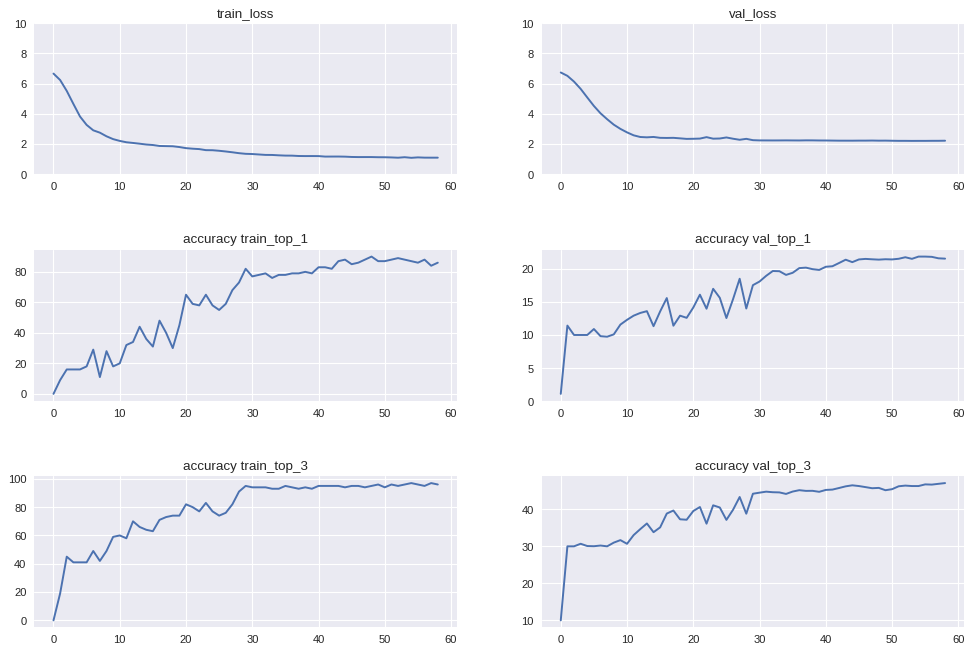

In [0]:
# Hyperparameters
args = Args(
        arch="resnet18", 
        workers=4, 
        epochs=100, 
        start_epoch=0, 
        batch_size=32, 
        lr=0.001, 
        momentum=0.9, 
        weight_decay=1e-4, 
        print_freq=1000, 
        resume="", 
        evaluate=False, 
        pretrained=False,
        n_early_stop=5
)


classifier1 = Classifier(args, transf)
classifier1.run_training()
classifier1.plot_results()

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   resnet18  | 60 | 90% | 22% |


## VGG-like architectures

__Question 4:__ Same question as before, but with a *VGG*. Which model do you recommend?

model_names ['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']
=> creating model 'vgg11'
Epoch: [0][3/4]	Time 4.140 (3.483)	Data 0.000 (0.096)	Loss 6.8978 (6.8901)	Prec@1 0.000 (1.000)	Prec@3 0.000 (1.000)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:257: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:258: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Test: [312/313]	Time 1.962 (0.156)	Loss 6.8263 (6.8282)	Prec@1 18.750 (10.000)	Prec@3 18.750 (10.000)
Epoch: [1][3/4]	Time 0.419 (0.501)	Data 0.000 (0.104)	Loss 6.6398 (6.7921)	Prec@1 25.000 (2.000)	Prec@3 25.000 (3.000)
Test: [312/313]	Time 0.083 (0.149)	Loss 6.6563 (6.6402)	Prec@1 18.750 (10.030)	Prec@3 31.250 (30.000)
Epoch: [2][3/4]	Time 0.366 (0.490)	Data 0.000 (0.092)	Loss 6.1763 (6.5004)	Prec@1 0.000 (14.000)	Prec@3 0.000 (27.000)
Test: [312/313]	Time 0.087 (0.150)	Loss 6.0394 (5.9758)	Prec@1 6.250 (10.000)	Prec@3 31.250 (30.000)
Epoch: [3][3/4]	Time 0.387 (0.479)	Data 0.000 (0.084)	Loss 2.9882 (5.0789)	Prec@1 50.000 (18.000)	Prec@3 50.000 (39.000)
Test: [312/313]	Time 0.085 (0.150)	Loss 5.5654 (5.1016)	Prec@1 6.250 (10.000)	Prec@3 31.250 (30.000)
Epoch: [4][3/4]	Time 0.385 (0.472)	Data 0.000 (0.079)	Loss 3.6140 (4.3979)	Prec@1 0.000 (6.000)	Prec@3 50.000 (40.000)
Test: [312/313]	Time 0.082 (0.150)	Loss 4.1668 (3.4074)	Prec@1 6.250 (10.000)	Prec@3 6.250 (30.000)
Epoch: [5][3/4]	

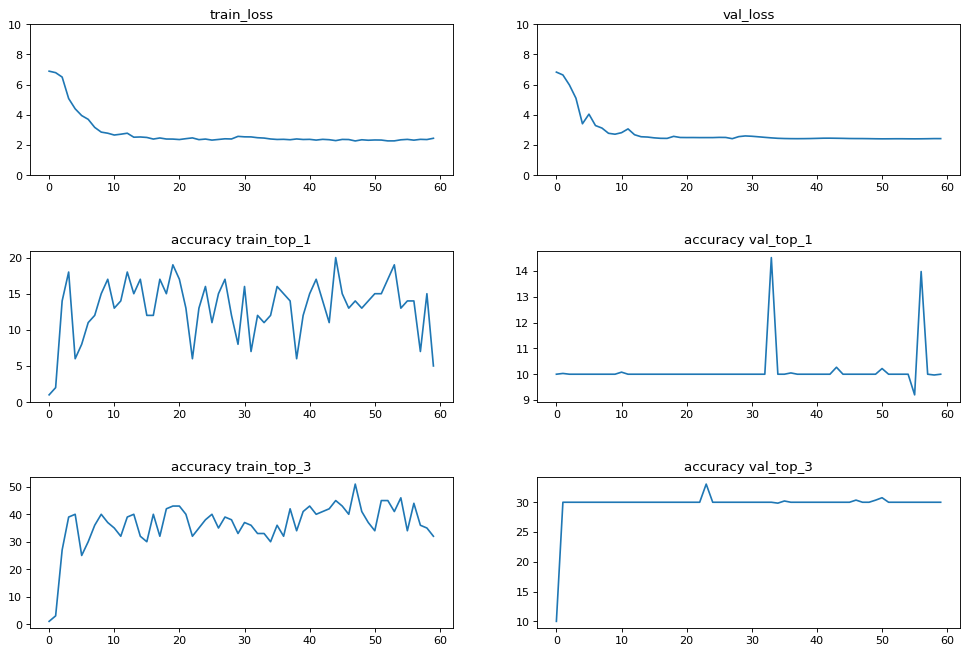

In [10]:
# Hyperparameters
args = Args(
        arch="vgg11", 
        workers=4, 
        epochs=60, 
        start_epoch=0, 
        batch_size=32, 
        lr=0.001, 
        momentum=0.9, 
        weight_decay=1e-4, 
        print_freq=1000, 
        resume="", 
        evaluate=False, 
        pretrained=False,
        n_early_stop=None
)

classifier2 = Classifier(args, transf)
classifier2.run_training()
classifier2.plot_results()

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   vgg11  | 10 | 15% | 10% |


I would recommend resnet18 model rather than vgg11. In fact, vgg11 didn't make an accuracy better than randomness. Its architecture may not be optimized for our data low quantity, even if we have tried multiple set of hyperparameters.

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on: https://pytorch.org/docs/stable/torchvision/models.html.

__Question 5:__ Pick a model from the list above, adapt it to CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

model_names ['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']
=> using pre-trained model 'resnet18'


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 89902925.90it/s]


Epoch: [0][3/4]	Time 1.221 (1.110)	Data 0.000 (0.116)	Loss 7.4038 (8.3932)	Prec@1 0.000 (0.000)	Prec@3 0.000 (2.000)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:257: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:258: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Test: [312/313]	Time 0.543 (0.086)	Loss 10.8425 (10.2244)	Prec@1 0.000 (0.000)	Prec@3 0.000 (0.000)
Epoch: [1][3/4]	Time 0.148 (0.262)	Data 0.000 (0.098)	Loss 5.6753 (6.6478)	Prec@1 0.000 (5.000)	Prec@3 25.000 (7.000)
Test: [312/313]	Time 0.036 (0.086)	Loss 9.4484 (9.2281)	Prec@1 0.000 (0.010)	Prec@3 0.000 (0.040)
Epoch: [2][3/4]	Time 0.146 (0.281)	Data 0.000 (0.116)	Loss 5.8308 (4.4505)	Prec@1 0.000 (28.000)	Prec@3 25.000 (39.000)
Test: [312/313]	Time 0.036 (0.085)	Loss 6.9211 (6.9698)	Prec@1 0.000 (1.730)	Prec@3 0.000 (4.400)
Epoch: [3][3/4]	Time 0.150 (0.273)	Data 0.000 (0.107)	Loss 3.1292 (2.3727)	Prec@1 50.000 (66.000)	Prec@3 75.000 (80.000)
Test: [312/313]	Time 0.036 (0.084)	Loss 6.3507 (6.1532)	Prec@1 18.750 (11.350)	Prec@3 18.750 (18.070)
Epoch: [4][3/4]	Time 0.148 (0.279)	Data 0.000 (0.112)	Loss 1.2193 (1.3074)	Prec@1 75.000 (72.000)	Prec@3 100.000 (92.000)
Test: [312/313]	Time 0.036 (0.083)	Loss 7.4173 (6.7047)	Prec@1 0.000 (5.490)	Prec@3 6.250 (10.680)
Epoch: [5][3/4]	Time 0

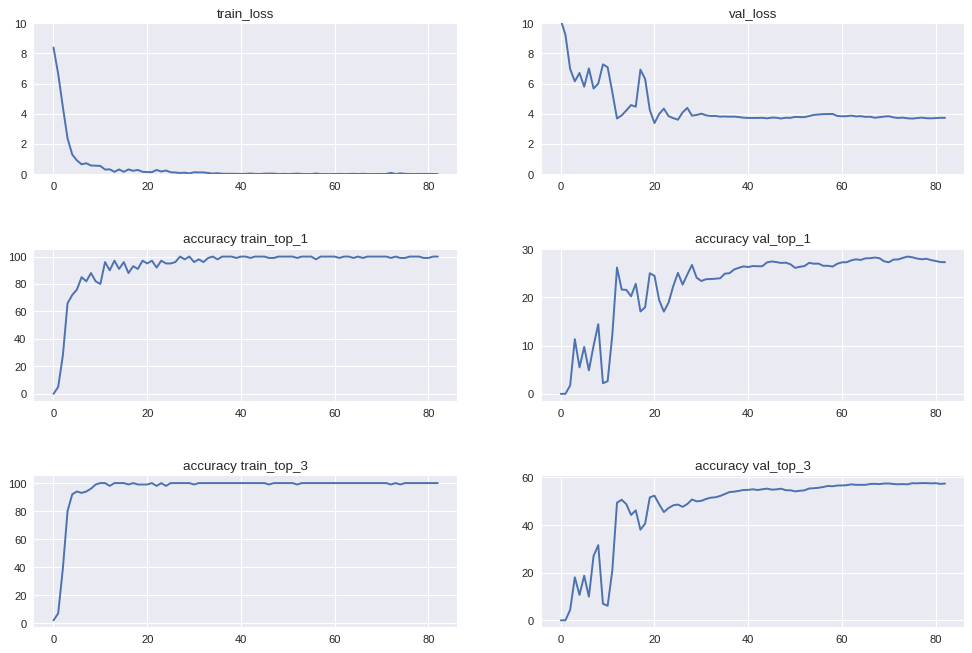

In [0]:
# Hyperparameters
args = Args(
        arch="resnet18", 
        workers=4, 
        epochs=100, 
        start_epoch=0, 
        batch_size=32, 
        lr=0.001, 
        momentum=0.9, 
        weight_decay=1e-4, 
        print_freq=1000, 
        resume="", 
        evaluate=False, 
        pretrained=True,
        n_early_stop=5
)

classifier3 = Classifier(args, transf)
classifier3.run_training()
classifier3.plot_results()

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   resnet18 pretrained  | 80 | 100% | 28% |


## DCGan features

GANs correspond to an unsupervised technique for generating images. In https://arxiv.org/pdf/1511.06434.pdf, Sec. 5.1 shows that the representation obtained from the Discriminator has some nice generalization properties on CIFAR10.

__Question 6:__  Using for instance a pretrained model from https://github.com/soumith/dcgan.torch combined with https://github.com/pytorch/examples/tree/master/dcgan, propose a model to train on $\mathcal{X}_{\text{train}}$. Train it and report its accuracy.

*Hint:* You can use the library: https://github.com/bshillingford/python-torchfile to load the weights of a model from torch(Lua) to pytorch(python).

In [0]:
imageSize= 32
batchSize=16
nz=256 #size of the latent z vector
ngf=128 # Starting Number of Filters in Generator
ndf=128 # Starting Number of Filters in Discriminator
nc = 1 # Number of Channels

In [0]:

#Discriminator Part of DCGAN
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(0))
        else:
            output = self.main(input)
        return output.view(-1, 1).squeeze(1)
    
    def get_features(self, input):
        
        out1 = self.main[0](input)
        out_conv1 = self.main[1](out1)
        
        out2 = self.main[2](out_conv1)
        out3 = self.main[3](out2)
        out_conv2 = self.main[4](out3)
        
        
        out4 = self.main[5](out_conv2)
        out5 = self.main[6](out4)
        out_conv3 = self.main[7](out5)
        
        out6 = self.main[8](out_conv3)
        out7 = self.main[9](out6)
        out_conv4 = self.main[10](out7)
        
        out8 = self.main[11](out_conv4)
        out_conv5 = self.main[12](out8)

        max_pool1 = nn.MaxPool2d(int(out_conv1.size(2) / 4))
        max_pool2 = nn.MaxPool2d(int(out_conv2.size(2) / 4))
        max_pool3 = nn.MaxPool2d(int(out_conv3.size(2) / 4))
        
        vector1 = max_pool1(out_conv1).view(input.size(0), -1).squeeze(1)
        vector2 = max_pool2(out_conv2).view(input.size(0), -1).squeeze(1)
        vector3 = max_pool3(out_conv3).view(input.size(0), -1).squeeze(1)
        
        return torch.cat((vector1, vector2, vector3), 1)
    


In [27]:
from sklearn import svm
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data
import torch.backends.cudnn as cudnn
import torch.nn as nn

import os
import torch.utils.data
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np

def train_dcgan():
    cudnn.benchmark = True
    discriminator_weight_path = './netD_epoch_299.pth'
    transform_train = transforms.Compose([
                                   transforms.Resize(imageSize),
                                   transforms.CenterCrop(imageSize),
                                   transforms.Grayscale(),
                                   transforms.ToTensor(),
                                   normalize
                                   ])

    transform_test = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        normalize
    ])

    trainset = CIFAR10(root=DATASET_PATH, train=True, download=True, transform=transform_train)

    #Define Valid Indices
    subset_indices = list(range(100))

    #Using Torch Subset DataLoader to Load the valid indices
    train_subset_loader = torch.utils.data.DataLoader(trainset, batch_size=100, sampler=torch.utils.data.SubsetRandomSampler(subset_indices))
    testset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False, num_workers=2)

    netD = Discriminator()
    for name, param in netD.named_parameters():
        if param.requires_grad:
            print(name,param.shape)

    netD.load_state_dict(torch.load(discriminator_weight_path))
    netD.cuda()
    netD.eval()

    input = torch.FloatTensor(batchSize, 3, imageSize, imageSize).cuda()
    train_features = np.array([])
    train_labels = np.array([])
    test_features = np.array([])
    test_labels = np.array([])

    #Get training Set Features
    for i, x in enumerate(train_subset_loader):
        imgs, label = x
        imgs = imgs.cuda()
        input.resize_as_(imgs).copy_(imgs)
        input_v = Variable(input)

        feature = netD.get_features(input_v)
        feature = feature.data.cpu().numpy()
        feature = feature.astype(np.float16)

        if train_features.size == 0:
            train_features = feature
            train_labels = label
        else:
            train_features = np.concatenate((train_features, feature), axis=0)
            train_labels = np.concatenate((train_labels, label), axis=0)

    #Get Validation Set Features
    for i, data in enumerate(testloader):
        imgs, label = data
        imgs = imgs.cuda()
        input.resize_as_(imgs).copy_(imgs)
        input_v = Variable(input)

        feature = netD.get_features(input_v)
        feature = feature.data.cpu().numpy()
        feature = feature.astype(np.float16)

        if test_features.size == 0:
            test_features = feature
            test_labels = label
        else:
            test_features = np.concatenate((test_features, feature), axis=0)
            test_labels = np.concatenate((test_labels, label), axis=0)

    print('Start SVM training')
    clf = svm.SVC(decision_function_shape='ovo')
    clf.fit(train_features, train_labels)

    print('Predict SVM')
    test_labels = test_labels.squeeze()
    test_labels = test_labels.data.numpy()
    predicted_labels = clf.predict(test_features)
    a = predicted_labels == test_labels

    accuracy = np.sum(predicted_labels == test_labels) / len(test_labels)
    print('DCGan SVM results: %.4f accuracy'%accuracy)

train_dcgan()

Files already downloaded and verified
Files already downloaded and verified
main.0.weight torch.Size([64, 1, 4, 4])
main.2.weight torch.Size([128, 64, 4, 4])
main.3.weight torch.Size([128])
main.3.bias torch.Size([128])
main.5.weight torch.Size([256, 128, 4, 4])
main.6.weight torch.Size([256])
main.6.bias torch.Size([256])
main.8.weight torch.Size([512, 256, 4, 4])
main.9.weight torch.Size([512])
main.9.bias torch.Size([512])
main.11.weight torch.Size([1, 512, 2, 2])


FileNotFoundError: ignored

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that:

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to:

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 7:__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

> 32*32 images indeed is a tiny resolution. Humans can still recognize which label to put on these images, then machines should be able to do so. Rotations of 90° would be a piece of cake as we have squared images. When we come to scaling, translation or non-square rotation, we will face the big issue of lack of pixel. 

> When performing a non-square rotation,  we will have to zoom into the image in order not to have dark spots on the corners, but with that few pexels, we may reconstruct non recognizable images. Zooming is not everything, we will have to resize the image into 32*32 dimension, using interpolation. We will have to duplicate pixels and facing an even bigger pixelisation.

> To adress such problem, we can apply gaussian filters to our images in order to smooth the low resolution. We could also try to refine the image quality using GANs



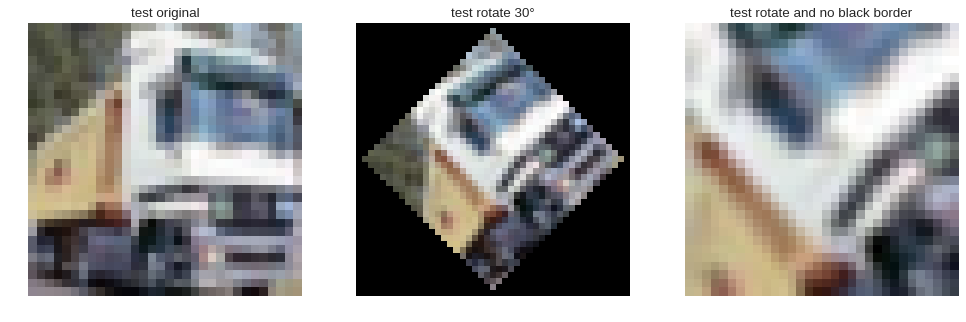

In [0]:
from scipy.ndimage import rotate
import cv2

im_test = X_train[1]

plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.title("test original")
plt.imshow(im_test)

plt.subplot(1, 3, 2)
plt.axis("off")
plt.title("test rotate 30°")
rotated = rotate(im_test, angle=45, reshape=True)
plt.imshow(rotated)

plt.subplot(1, 3, 3)
plt.axis("off")
plt.title("test rotate and no black border")
crop_value=12
rotate_crop = rotated[crop_value:-crop_value, crop_value:-crop_value]

rotate_crop = cv2.resize(rotate_crop, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
plt.imshow(rotate_crop)


## Data augmentations

__Question 8:__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ and __Question 4__ with them and report the accuracies.

model_names ['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']
=> creating model 'resnet18'
Epoch: [0][3/4]	Time 0.052 (0.088)	Data 0.000 (0.040)	Loss 6.8156 (7.0264)	Prec@1 0.000 (0.000)	Prec@3 0.000 (0.000)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:257: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:258: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Test: [312/313]	Time 0.009 (0.014)	Loss 6.8521 (6.8493)	Prec@1 0.000 (0.220)	Prec@3 0.000 (0.990)
Epoch: [1][3/4]	Time 0.044 (0.085)	Data 0.000 (0.046)	Loss 6.2598 (6.5232)	Prec@1 0.000 (0.000)	Prec@3 0.000 (4.000)
Test: [312/313]	Time 0.010 (0.015)	Loss 6.3180 (6.4339)	Prec@1 18.750 (5.670)	Prec@3 18.750 (11.970)
Epoch: [2][3/4]	Time 0.040 (0.080)	Data 0.000 (0.043)	Loss 4.6787 (5.6247)	Prec@1 50.000 (13.000)	Prec@3 50.000 (29.000)
Test: [312/313]	Time 0.009 (0.014)	Loss 5.4507 (5.2330)	Prec@1 12.500 (9.620)	Prec@3 43.750 (29.400)
Epoch: [3][3/4]	Time 0.039 (0.093)	Data 0.000 (0.056)	Loss 3.4535 (4.4641)	Prec@1 0.000 (13.000)	Prec@3 100.000 (50.000)
Test: [312/313]	Time 0.009 (0.014)	Loss 5.8433 (4.9592)	Prec@1 18.750 (10.890)	Prec@3 43.750 (31.650)
Epoch: [4][3/4]	Time 0.045 (0.087)	Data 0.000 (0.048)	Loss 4.1696 (3.5643)	Prec@1 25.000 (23.000)	Prec@3 50.000 (50.000)
Test: [312/313]	Time 0.009 (0.014)	Loss 7.6084 (5.5528)	Prec@1 18.750 (12.270)	Prec@3 31.250 (30.950)
Epoch: [5][3/4]	

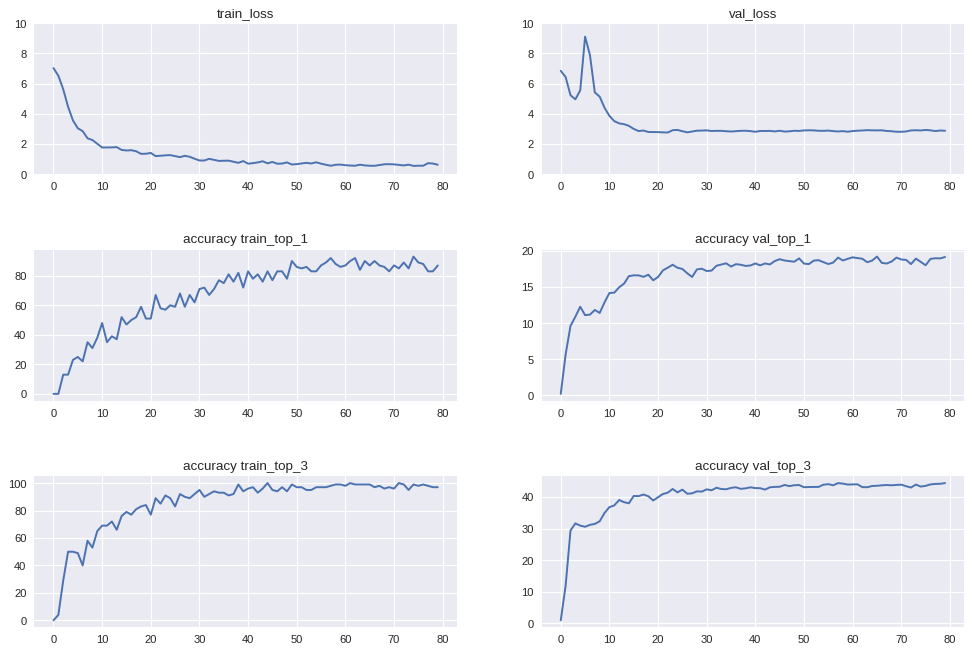

In [0]:
# Hyperparameters
args = Args(
        arch="resnet18", 
        workers=4, 
        epochs=80, 
        start_epoch=0, 
        batch_size=32, 
        lr=0.001, 
        momentum=0.9, 
        weight_decay=1e-4, 
        print_freq=1000, 
        resume="", 
        evaluate=False, 
        pretrained=False,
        n_early_stop=None
)

# Transformation definition
transf2 = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.RandomHorizontalFlip(),
#      transforms.RandomAffine(degrees=15, translate=(0.05, 0.05), scale=(0.9, 1.1)),
     transforms.RandomVerticalFlip(),
     transforms.RandomCrop(32, padding=4),
     transforms.ToTensor(),
     normalize
    ])


classifier4 = Classifier(args, transf2)
classifier4.run_training()
classifier4.plot_results()


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   resnet18  | 20 | 90% | 20% |


model_names ['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']
=> creating model 'vgg11'
Epoch: [0][3/4]	Time 0.108 (0.145)	Data 0.000 (0.045)	Loss 6.7520 (6.8480)	Prec@1 25.000 (3.000)	Prec@3 25.000 (6.000)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:257: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:258: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Test: [312/313]	Time 0.014 (0.018)	Loss 6.4619 (6.4295)	Prec@1 6.250 (10.000)	Prec@3 12.500 (30.000)
Epoch: [1][3/4]	Time 0.091 (0.166)	Data 0.000 (0.083)	Loss 3.9381 (5.4224)	Prec@1 50.000 (16.000)	Prec@3 75.000 (39.000)
Test: [312/313]	Time 0.014 (0.018)	Loss 19.7428 (17.6991)	Prec@1 6.250 (10.000)	Prec@3 25.000 (30.000)
Epoch: [2][3/4]	Time 0.091 (0.140)	Data 0.000 (0.058)	Loss 6.4818 (9.4922)	Prec@1 0.000 (9.000)	Prec@3 25.000 (30.000)
Test: [312/313]	Time 0.014 (0.018)	Loss 6.2931 (6.4824)	Prec@1 18.750 (10.000)	Prec@3 18.750 (30.000)
Epoch: [3][3/4]	Time 0.092 (0.149)	Data 0.000 (0.067)	Loss 5.7469 (6.2347)	Prec@1 0.000 (7.000)	Prec@3 25.000 (30.000)
Test: [312/313]	Time 0.014 (0.018)	Loss 5.6645 (5.9432)	Prec@1 6.250 (10.000)	Prec@3 25.000 (30.000)
Epoch: [4][3/4]	Time 0.092 (0.149)	Data 0.000 (0.067)	Loss 3.8660 (6.0499)	Prec@1 25.000 (14.000)	Prec@3 25.000 (39.000)
Test: [312/313]	Time 0.014 (0.018)	Loss 6.5426 (6.2869)	Prec@1 6.250 (10.000)	Prec@3 6.250 (30.000)
Epoch: [5][3/

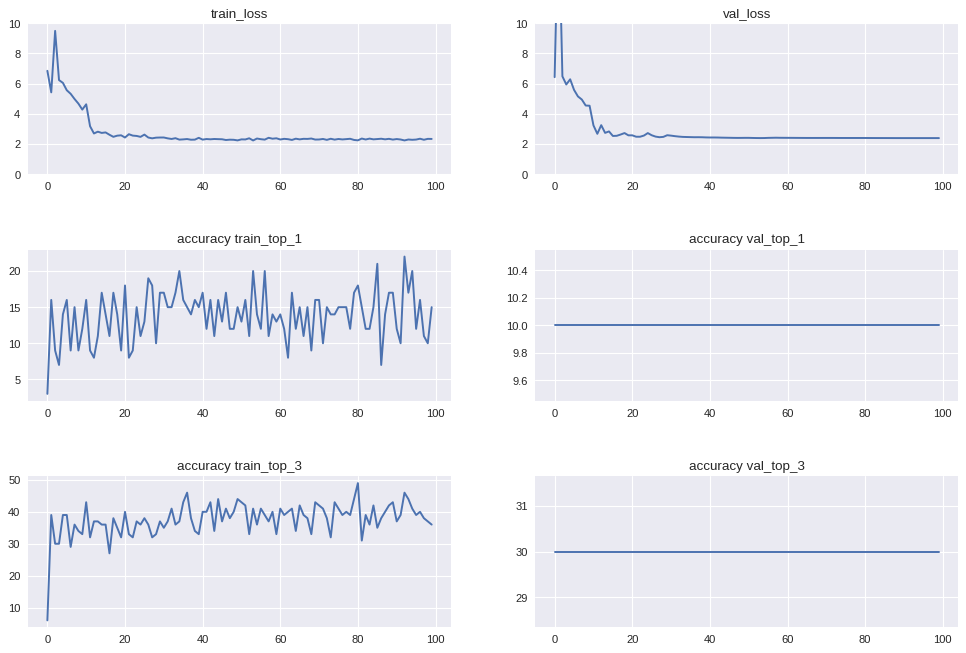

In [0]:
# Hyperparameters
args = Args(
        arch="vgg11", 
        workers=4, 
        epochs=100, 
        start_epoch=0, 
        batch_size=32, 
        lr=0.01, 
        momentum=0.9, 
        weight_decay=1e-4, 
        print_freq=1000, 
        resume="", 
        evaluate=False, 
        pretrained=False,
        n_early_stop=None
)

classifier5 = Classifier(args, transf2)
classifier5.run_training()
classifier5.plot_results()

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   vgg11  | 10 | 16% | 10% |

Once again, vgg11 cannot learn on our dataset, even with data augmentation


## Wavelets

__Question 9:__ Use a Scattering Transform as an input to a ResNet-like architecture. You can find a baseline here: https://arxiv.org/pdf/1703.08961.pdf.

*Hint:* You can use the following package: https://www.kymat.io/

In [0]:
!pip install kymatio

In [0]:
from kymatio import Scattering2D

# Hyperparameters
args = Args(
        arch="resnet18", 
        workers=4, 
        epochs=10, 
        start_epoch=0, 
        batch_size=10, 
        lr=0.01, 
        momentum=0.9, 
        weight_decay=1e-4, 
        print_freq=1000, 
        resume="", 
        evaluate=False, 
        pretrained=False
)

transf_scat = transforms.Compose(
    [
        Scattering2D(J=2, shape=(32, 32)),
        transforms.ToPILImage(),
        transforms.ToTensor(),
        normalize
    ])

# classifier6 = Classifier(args, transf_scat)
# classifier6.run_training()
# classifier6.plot_results()

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.276830


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 4472.7316, Accuracy: 976/10000 (9.76%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 5.133143

Test set: Average loss: 191.7867, Accuracy: 1115/10000 (11.15%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 3.579576

Test set: Average loss: 5.0377, Accuracy: 989/10000 (9.89%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 2.194558

Test set: Average loss: 2.7795, Accuracy: 1000/10000 (10.00%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 2.300965

Test set: Average loss: 2.4132, Accuracy: 1000/10000 (10.00%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 2.135362

Test set: Average loss: 2.4039, Accuracy: 1138/10000 (11.38%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 2.163749

Test set: Average loss: 2.3296, Accuracy: 1287/10000 (12.87%)

Train Epoch: 8 [0/50000 (0%)]	Loss: 2.100292

Test set: Average loss: 2.3506, Accuracy: 1425/10000 (14.25%)

Train Epoch: 9 [0/50000 (0%)]	Loss: 1.987098

Test set: Average loss: 2.3578, Accuracy: 1202/10000 (12.02%)

Train Epoch: 10 [0/50000 (0%)]	Loss: 2.122210

Test set: Averag

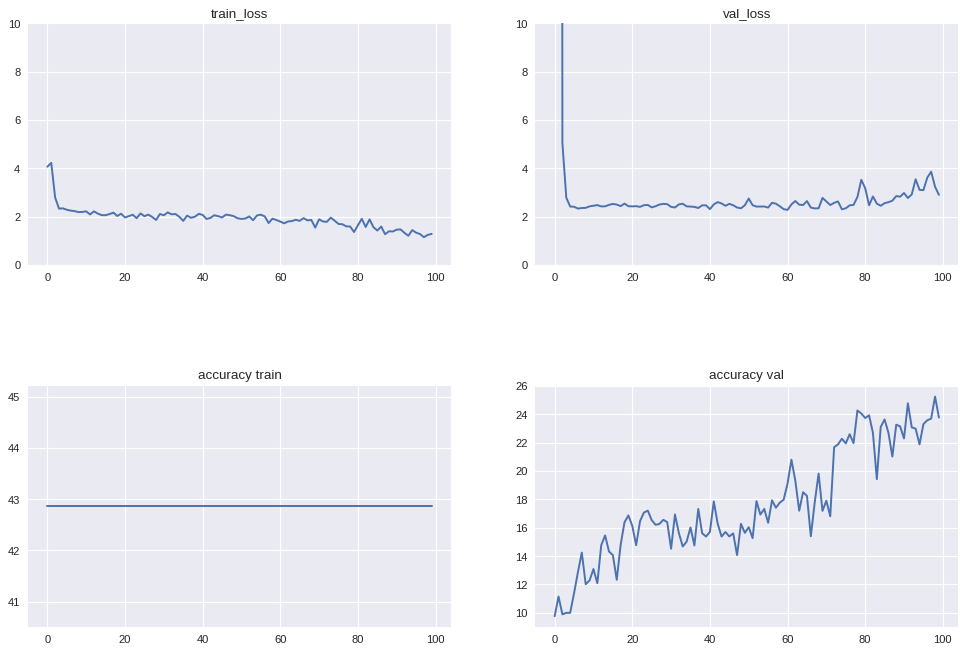

In [0]:
import torch.optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from kymatio import Scattering2D
import torch
import torch.nn as nn
import torchvision
from torch.utils import data

class BasicBlock(nn.Module):
        def __init__(self, inplanes, planes, stride=1, downsample=None):
            super(BasicBlock, self).__init__()
            self.conv1 = self.conv3x3(inplanes, planes, stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.relu = nn.ReLU(inplace=True)
            self.conv2 = self.conv3x3(planes, planes)
            self.bn2 = nn.BatchNorm2d(planes)
            self.downsample = downsample
            self.stride = stride

            
        def forward(self, x):
            residual = x

            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)
            out = self.conv2(out)
            out = self.bn2(out)

            if self.downsample is not None:
                residual = self.downsample(x)

            out += residual
            out = self.relu(out)
            return out
   

        def conv3x3(self, in_planes, out_planes, stride=1):
            """3x3 convolution with padding"""
            return nn.Conv2d(
                in_planes, 
                out_planes, 
                kernel_size=3, 
                stride=stride,
                padding=1, 
                bias=False)


class Scattering2dResNet(nn.Module):
    def __init__(self, in_channels,  k=2, n=4, num_classes=10):
        super(Scattering2dResNet, self).__init__()
        self.inplanes = 16 * k
        self.ichannels = 16 * k
        self.K = in_channels
        self.init_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels, eps=1e-5, affine=False),
            nn.Conv2d(in_channels, self.ichannels,
                  kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.ichannels),
            nn.ReLU(True)
        )

        self.layer2 = self._make_layer(BasicBlock, 32 * k, n)
        self.layer3 = self._make_layer(BasicBlock, 64 * k, n)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self.fc = nn.Linear(64 * k * 4, num_classes)

        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    
    def forward(self, x):
        x = x.view(x.size(0), self.K, 8, 8)
        x = self.init_conv(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class ClassifierScat:
    
    def __init__(self, args):
        self.args = args
    
    def train(self, model, device, train_subset_loader, optimizer, epoch, scattering):
        les_acc = []
        les_loss = []
        
        model.train()
        for batch_idx, (data, target) in enumerate(train_subset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(scattering(data))
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            
            accuracy = 100. * batch_idx / len(train_subset_loader)
            les_acc.append(accuracy)
            les_loss.append(loss.item())
            
            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_subset_loader.dataset),
                    accuracy, loss.item()))
        
        # Store average of loss and accuracy for plots
        self.les_train_loss.append(sum(les_loss)/len(les_loss))
        self.les_train_acc.append(sum(les_acc)/len(les_acc))

    def test(self, model, device, testloader, scattering):
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in testloader:
                data, target = data.to(device), target.to(device)
                output = model(scattering(data))
                test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(testloader.dataset)
        accuracy = 100. * correct / len(testloader.dataset)
        # Store values for plot
        self.les_val_loss.append(test_loss)
        self.les_val_acc.append(accuracy)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(testloader.dataset), accuracy))

        
    def run_train_scatter(self):
        try_cuda = False
        device = 'cuda' if torch.cuda.is_available() and try_cuda else 'cpu'

        scattering = Scattering2D(J=2, shape=(32, 32), max_order=1)
        K = 17*3
        
        model = Scattering2dResNet(K, 2).to(device)
#         model = Scattering2dResNet(K, 2).cuda()
        transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize])

        transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize])

        trainset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True, download=True, transform=transform_train)

        subset_indices = list(range(100))
        train_subset_loader = torch.utils.data.DataLoader(trainset, batch_size=self.args.batch_size, sampler=data.SubsetRandomSampler(subset_indices))
        testset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=False, download=True, transform=transform_test)
        testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
        
        optimizer = torch.optim.SGD(model.parameters(), lr=self.args.lr, momentum=self.args.momentum, weight_decay=self.args.weight_decay)
        
        self.les_epoch = []
        self.les_train_loss = []
        self.les_val_loss = []
        self.les_train_acc = []
        self.les_val_acc = []
        
        for epoch in range(self.args.start_epoch, self.args.epochs):
            self.les_epoch.append(epoch)
            self.train(model, device, train_subset_loader, optimizer, epoch+1, scattering)
            self.test(model, device, testloader, scattering)

    def plot_results(self):
        """ Plot results of training
        """

        les_plot = [
            ["train_loss", self.les_train_loss], 
            ["val_loss", self.les_val_loss], 
            ["accuracy train", self.les_train_acc], 
            ["accuracy val", self.les_val_acc], 
        ]

        plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
        plt.subplots_adjust(wspace=0.2, hspace=0.5)

        for id_plot in range(0, len(les_plot), 2):
            # train plot
            plt.subplot(len(les_plot)//2, 2, id_plot+1)
            plt.title(les_plot[id_plot][0])
            plt.plot(self.les_epoch, les_plot[id_plot][1])

            if "loss" in les_plot[id_plot][0]:
                axes = plt.gca()
                axes.set_ylim([0,10])

            # validation plot
            plt.subplot(len(les_plot)//2, 2, id_plot+2)
            plt.title(les_plot[id_plot+1][0])
            plt.plot(self.les_epoch, les_plot[id_plot+1][1])

            if "loss" in les_plot[id_plot][0]:
                axes = plt.gca()
                axes.set_ylim([0,10])

        plt.show()
    
# Hyperparameters
args = Args(
        epochs=100, 
        start_epoch=0, 
        batch_size=16, 
        lr=0.1, 
        momentum=0.9, 
        weight_decay=1e-4
)

            
classifier_scat = ClassifierScat(args)
classifier_scat.run_train_scatter()
classifier_scat.plot_results()


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|  resnet_scat  | 10 | 43% | 24% |

24% validation accuracy and growing, but we cannot see further easily as training is very very long..


# Weak supervision

Weakly supervised techniques permit to tackle the issue of labeled data. An introduction to those techniques can be found here: https://hazyresearch.github.io/snorkel/blog/ws_blog_post.html.

__(Open) Question 10:__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

# Conclusions

__Question 11:__ Write a short report explaining the pros and the cons of each methods that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

Note : All plots have been done step-by-step in the jupyter notebook.

- Models can have different behaviours during the traning. For instance, we achieved far better results using resnet18 model facing vgg11. We can play with a lot of models to find the best ones that fit to our needs, but we may also look at the original dataset and choose the pretrained model as it is closer to our own dataset. 

- More imortantly, it appears that pretrained models is a major asset we can use when facing low-quantity datasets. We converge faster, and better than randomly assigned weights. This also is computational-time efficient as we just have to fine tuned our weights to our dataset. Still, we have to keep in mind that such models have to be quite close to the data we will use, and as seen in class, models trained on cats and dogs may not be optimal to recognize brain waves linked to epilepsia for instance. Also, such process still can benefits from other processes as data augmentation or preprocessing.

- Data augmentation is quite helpful to the model precision and to prevent overfitting as we saw when running again resnet18 with an augmented dataset in question8. Data augmentation can help obtain better results and reduce data biases. Data augmentation can take many ways, from rotational to translational passing by random cropping. Data preprocessing can also help the model performance and reduce the biases in the data: the gaussian filter can help us in this objecive as we try to reduce the impact of the size changing. 

- When it comes to data scattering, we have saw it allows the model to achieve great results! In our case, the training was very slow. Still throght multiple hours of training, we managed to outreach the result of classical resnet training. We don't hesitate that with more times, we would have get even better results.